## Setup and Import Libraries

In [1]:
import os
from typing_extensions import TypedDict
from typing import Annotated
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_tavily import TavilySearch
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from pprint import pprint
from IPython.display import Image, display
from dotenv import load_dotenv


In [2]:
load_dotenv()

True

In [3]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct-agent"

In [4]:
llm = ChatGroq(model="gemma2-9b-it")

## Creating Arxiv Tool

In [5]:
arxiv_api_wrapper = ArxivAPIWrapper(
    top_k_results=2, 
    doc_content_chars_max=500
)

arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

print(arxiv_tool.name)

arxiv


In [6]:
arxiv_tool.invoke(input="Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

## Creating Wikipedia Tool

In [7]:
wikipedia_api_wrapper = WikipediaAPIWrapper(
    top_k_results=1,
    doc_content_chars_max=500
)

wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)

print(wikipedia_tool.name)

wikipedia


In [8]:
wikipedia_tool.invoke(input="What is Machine Learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

## Creating Custom Tools

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def subtract(a: int, b: int) -> int:
    """Subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

## Create Tavily Search Tool

In [10]:
tavily_tool = TavilySearch(
    max_results=3,
    topic="general", 
)

In [ ]:
tavily_tool.invoke(input="What happened at the last wimbledon")

{'query': 'What happened at the last wimbledon',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.youtube.com/watch?v=tQU8vQvXKRQ',
   'title': 'Amanda Anisimova | Post-match Press Conference | Wimbledon 2025',
   'content': "What went wrong | Amanda Anisimova | Post-match Press Conference | Wimbledon 2025\nWimbledon\n2470000 subscribers\n3250 likes\n343622 views\n12 Jul 2025\nUSA's Amanda Anisimova speaks after tough Ladies' Final loss to Poland's Iga Swiatek at Wimbledon 2025.\n \n#Wimbledon #Tennis #Interview #Wimbledon2025 #TheresOnlyOneWimbledon \n\nSUBSCRIBE to keep up with all The Championships action and news!  \n\nJoin myWimbledon for a personalised Wimbledon experience: http://wimbledon.com/mywimbledon \n\nTo follow all of the action as it happens go to: https://www.wimbledon.com/en_GB/scores/index.html \n\nTo license Wimbledon footage, visit: https://bit.ly/3fy0RbA\n\n",
   'score': 0.40995342,
   'raw_content': None},
  {'url':

In [12]:
tavily_tool.invoke("Provide me the recent AI news for march 3rd 2025")

{'query': 'Provide me the recent AI news for march 3rd 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://theaitrack.com/ai-news-march-2025-in-depth-and-concise/',
   'title': 'AI News March 2025: In-Depth and Concise - The AI Track',
   'content': 'AI NEWS March 2025 · OpenAI Secures Historic $40 Billion Investment at $300 Billion Valuation · Runway Released Gen-4 Video Generation Model · Alibaba Launches',
   'score': 0.9008183,
   'raw_content': None},
  {'url': 'https://www.linkedin.com/pulse/weekly-ai-news-3-march-2025-aiforbusinessnet-johan-steyn-qrumf',
   'title': 'Weekly AI News: 3 March 2025 - AIforBusiness.net - LinkedIn',
   'content': "This week's AI update explores some of the most impactful developments shaping technology and society. OpenAI has unveiled GPT-4.5, a cutting-",
   'score': 0.89279664,
   'raw_content': None},
  {'url': 'https://www.akhia.com/insights/benthinking/ai-round-up-week-of-march-03-2025',
   'title':

## Combining and Binding Tools

In [13]:
tools = [
    arxiv_tool, wikipedia_tool, tavily_tool,
    add, subtract, multiply, divide
]

In [14]:
llm_with_tools = llm.bind_tools(tools=tools)

In [15]:
query = "What is the recent AI News"

llm_with_tools.invoke([HumanMessage(content=query)])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xrjnhrgvz', 'function': {'arguments': '{"query":"recent AI news","time_range":"day"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 3859, 'total_tokens': 3953, 'completion_time': 0.170909091, 'prompt_time': 0.073084778, 'queue_time': 0.269766061, 'total_time': 0.243993869}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--be0ab222-103c-4450-ae6d-392fabbb8ec9-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news', 'time_range': 'day'}, 'id': 'xrjnhrgvz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3859, 'output_tokens': 94, 'total_tokens': 3953})

In [16]:
llm_with_tools.invoke([HumanMessage(content=query)]).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'recent AI news', 'time_range': 'day'},
  'id': '1t63fjmza',
  'type': 'tool_call'}]

## Creating Graph

In [17]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [18]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

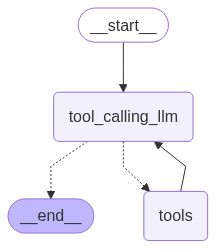

In [19]:
# Build graph
graph_builder = StateGraph(State)

# Add Nodes
graph_builder.add_node(node="tool_calling_llm", action=tool_calling_llm)
graph_builder.add_node(node="tools", action=ToolNode(tools))

# Add Edges
graph_builder.add_edge(start_key=START, end_key="tool_calling_llm")
graph_builder.add_conditional_edges(
    source="tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    path=tools_condition,
)
graph_builder.add_edge(start_key="tools", end_key="tool_calling_llm")


compiled_graph = graph_builder.compile()

# View
display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [23]:
query = "What is the latest FIFA World Cup news, also add 5 plus 5 and then multiply by 10"

messages = compiled_graph.invoke({"messages":HumanMessage(content=query)})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the latest FIFA World Cup news, also add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (p3jfrgz8m)
 Call ID: p3jfrgz8m
  Args:
    query: FIFA World Cup latest news
================================= Tool Message =================================
Name: tavily_search

{"query": "FIFA World Cup latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cbsnews.com/tag/world-cup/", "title": "World Cup news - Today's latest updates", "content": "FIFA released its match schedule for the 2026 World Cup and announced the final will be played at the MetLife Stadium in New Jersey. U.S. Men's National Team", "score": 0.7722049, "raw_content": null}, {"url": "https://www.nbcnews.com/sports/world-cup", "title": "FIFA World Cup 2026: Latest News, Photo and Video", "conte

In [24]:
query = "What is Machine Learning"

messages = compiled_graph.invoke({"messages":HumanMessage(content=query)})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is Machine Learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (kv6jmavpr)
 Call ID: kv6jmavpr
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

Machine learning (ML) is a field of stu